# Analysis of water supply interruptions by populated areas on the territory of Dobrich Waterworks

In [3]:
import requests
from bs4 import BeautifulSoup
import csv

# Base URL
base_url = "https://vikdobrich.bg/Info/BreakdownIndex?page="

# Output CSV file
output_file = "breakdown_info.csv"

# Initialize CSV file with headers
with open(output_file, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["date", "failure_info"])

# Function to scrape a single page
def scrape_page(page_number):
    url = base_url + str(page_number)
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Find all news-box divs that contain the tables
    news_boxes = soup.find_all('div', class_='news-box')
    
    for box in news_boxes:
        # Extract the date from the first <tr> and first <td>
        date_row = box.find('tr')
        date = date_row.find('td').get_text(strip=True)
        
        # Extract failure information from the second <tr> and all <p> tags inside it
        failure_info_row = date_row.find_next_sibling('tr')
        failure_info = "\n".join([p.get_text(strip=True) for p in failure_info_row.find_all('p')])
        
        # Write to CSV
        with open(output_file, mode='a', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow([date, failure_info])

    return True

# Loop through all pages
for page in range(1, 794):  # There are 793 pages
    scrape_page(page)

print(f"Scraping completed. Data saved to {output_file}.")


Scraping completed. Data saved to breakdown_info.csv.


In [4]:
import pandas as pd

In [5]:
vik_data = pd.read_csv("breakdown_info.csv")

In [6]:
vik_data

,date,failure_info
0,14.08.2024,"- Район Добрич: ЖК ""Дружба 1""\n- Район Добрич-..."
1,13.08.2024,- Район Добрич: На 13. 08. 2024 г. В периода 0...
2,12.08.2024,- Район Добрич: На 13. 08. 2024 г. В периода 0...
3,10.08.2024,- Район Добрич-селска: с. Камен\n- Район Кавар...
4,09.08.2024,- Район Добрич: кв. Рилци-ул. Твърдица; Лозята...
...,...,...
2374,19.05.2017,- Район Добрич: Телевизионна Кула; Липите 8-10...
2375,18.05.2017,"- Район Добрич: ул. Крайовски договор 49, Пл. ..."
2376,17.05.2017,- Район Добрич: ул. Детелина №25а; кв. Рилци у...
2377,16.05.2017,- Район Добрич: ул. Струма 2 ул. Хан Тервел Х...


In [3]:
places_data = pd.read_csv("places.txt", header=None, names=["name"])

In [4]:
places_data

,name
0,Абрит
1,Александрия
2,Александър Стамболийски
3,Алцек
4,Ангеларий
...,...
210,Черна
211,Черноморци
212,Чернооково
213,Честименско


In [5]:
import csv
import re
import pandas as pd

# Load the places dataset
place_names = places_data['name'].tolist()  # Convert the column to a list

# Input and output files
input_file = "breakdown_info.csv"
output_file = "places_info.csv"

# Function to check for places in failure_info and return found places
def find_places(failure_info, place_names):
    found_places = []
    for place in place_names:
        if re.search(r'\b' + re.escape(place) + r'\b', failure_info):
            found_places.append(place)
    return ', '.join(found_places)

# Read the original CSV and create the new dataset
with open(input_file, mode='r', newline='', encoding='utf-8') as infile, \
     open(output_file, mode='w', newline='', encoding='utf-8') as outfile:
    
    reader = csv.DictReader(infile)
    writer = csv.writer(outfile)
    
    # Write header for the new dataset
    writer.writerow(["date", "places"])
    
    for row in reader:
        date = row['date']
        failure_info = row['failure_info']
        places = find_places(failure_info, place_names)
        
        if places:  # Only write rows where at least one place was found
            writer.writerow([date, places])

print(f"New dataset with places saved to {output_file}.")


New dataset with places saved to places_info.csv.


In [31]:
no_water_supply = pd.read_csv("places_info.csv")

In [32]:
no_water_supply

,date,places
0,14.08.2024,"Балчик, Безводица, Горун, Добрич, Дропла, Змее..."
1,13.08.2024,"Балчик, Бдинци, Безводица, Владимирово, Вратар..."
2,12.08.2024,"Ангеларий, Балик, Балчик, Бдинци, Белгун, Влад..."
3,10.08.2024,"Ангеларий, Балик, Добрич, Дъбовик, Зърнево, Ка..."
4,09.08.2024,"Ангеларий, Балик, Балчик, Безводица, Добрич, Д..."
...,...,...
2374,19.05.2017,"Абрит, Балчик, Българево, Добрич, Каварна, Кар..."
2375,18.05.2017,"Балчик, Батово, Безводица, Гурково, Добрич, До..."
2376,17.05.2017,"Безводица, Безмер, Добрин, Добрич, Каварна, Ка..."
2377,16.05.2017,"Балчик, Батово, Добрич, Дропла, Жегларци, Крас..."


In [33]:
import pandas as pd

# Load the dataset
df = pd.read_csv('places_info.csv')

# Function to clean place names
def clean_place_name(place):
    return place.strip()

# Split the places column into individual rows
df['places'] = df['places'].str.split(',')  # Split places by comma
df = df.explode('places')  # Create a new row for each place

# Clean the place names (remove leading/trailing spaces)
df['places'] = df['places'].apply(clean_place_name)

# Optional: Remove duplicates if the same place is listed multiple times for the same date
df = df.drop_duplicates(subset=['date', 'places'])

# Save the cleaned and organized dataset
output_file = "tidy_places_info.csv"
df.to_csv(output_file, index=False)

print(f"Data cleaned and organized. Saved to {output_file}.")


Data cleaned and organized. Saved to tidy_places_info.csv.


In [38]:
import pandas as pd
from itertools import product

# Load your existing dataset
df = pd.read_csv('tidy_places_info.csv')

# Ensure the 'date' column is parsed correctly with the specific format
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

# Extract unique dates and places
all_dates = pd.date_range(start=df['date'].min(), end=df['date'].max()).to_list()
all_places = df['places'].unique().tolist()

# Create a DataFrame with all combinations of dates and places
full_combinations = pd.DataFrame(list(product(all_dates, all_places)), columns=['date', 'places'])

# Add the interruption column with value 1 for interruptions
df['interruption'] = 1

# Merge the full combinations with your original dataset
full_df = pd.merge(full_combinations, df, on=['date', 'places'], how='left')

# Fill missing values in the interruption column with 0 (no interruption)
full_df['interruption'].fillna(0, inplace=True)

# Convert interruption to integer type
full_df['interruption'] = full_df['interruption'].astype(int)

# Save the completed dataset
output_file = "complete_interruption_data.csv"
full_df.to_csv(output_file, index=False)

print(f"Complete dataset saved to {output_file}.")

Complete dataset saved to complete_interruption_data.csv.


In [39]:
complete_interruption_data = pd.read_csv("complete_interruption_data.csv")

In [40]:
complete_interruption_data

,date,places,interruption
0,2017-05-15,Балчик,1
1,2017-05-15,Безводица,0
2,2017-05-15,Горун,0
3,2017-05-15,Добрич,1
4,2017-05-15,Дропла,0
...,...,...,...
558934,2024-08-14,Сърнино,0
558935,2024-08-14,Полковник Минково,0
558936,2024-08-14,Било,0
558937,2024-08-14,Професор Златарски,0


In [6]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# Load the places dataset
# places_df = pd.read_csv('places.csv')

# Initialize Nominatim API with user-agent
geolocator = Nominatim(user_agent="place_geocoder")

# Add a rate limiter to avoid overwhelming the service
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Function to geocode place with specific municipality and region
def get_coordinates(place_name):
    location_query = f"България, област Добрич, {place_name}"
    location = geocode(location_query)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# Apply the geocoding function to the 'name' column
places_data['latitude'], places_data['longitude'] = zip(*places_data['name'].apply(get_coordinates))

# Save the new dataframe with coordinates to a new CSV file
output_file = "places_with_coordinates.csv"
places_data.to_csv(output_file, index=False)

print(f"Geocoding completed. Coordinates saved to {output_file}.")


KeyboardInterrupt: 

In [46]:
places_with_coordinates = pd.read_csv("places_with_coordinates.csv")

In [47]:
places_with_coordinates

,name,latitude,longitude
0,Абрит,43.907480,27.795690
1,Александрия,43.885250,27.748350
2,Александър Стамболийски,43.685367,28.357714
3,Алцек,43.774920,27.542570
4,Ангеларий,43.828950,27.524460
...,...,...,...
210,Черна,43.760020,27.669990
211,Черноморци,43.669690,28.444010
212,Чернооково,43.710500,28.171110
213,Честименско,43.779420,27.348210


In [49]:
import pandas as pd

# Load the complete interruption dataset
interruption_df = pd.read_csv('complete_interruption_data.csv')

# Load the places with coordinates dataset
coordinates_df = pd.read_csv('places_with_coordinates.csv')

# Merge the datasets on the 'places' column
merged_df = pd.merge(interruption_df, coordinates_df, on='name', how='left')

# Optionally: Handle any missing coordinates (if places were not found in coordinates dataset)
merged_df['latitude'].fillna(0, inplace=True)
merged_df['longitude'].fillna(0, inplace=True)

# Save the final dataset with coordinates included
output_file = "interruption_data_with_coordinates.csv"
merged_df.to_csv(output_file, index=False)

print(f"Final dataset with coordinates saved to {output_file}.")


Final dataset with coordinates saved to interruption_data_with_coordinates.csv.


In [12]:
import pandas as pd
import folium
from folium.plugins import TimestampedGeoJson
from ipywidgets import interact
import ipywidgets as widgets

# Load the data
df = pd.read_csv('interruption_data_with_coordinates.csv')

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Function to filter and display the map
def plot_map(date):
    # Filter data for the selected date
    filtered_df = df[df['date'] == pd.to_datetime(date)]
    
    # Create a base map centered around a specific location
    m = folium.Map(location=[43.5688397, 27.8297415], zoom_start=10)
    
    # Add markers for each place
    for _, row in filtered_df.iterrows():
        folium.CircleMarker(
            location=(row['latitude'], row['longitude']),
            radius=8,
            color='red' if row['interruption'] == 1 else 'green',
            fill=True,
            fill_color='red' if row['interruption'] == 1 else 'green',
            fill_opacity=0.6,
            popup=f"{row['name']} - {'Interruption' if row['interruption'] == 1 else 'No Interruption'}"
        ).add_to(m)
    
    # Display the map
    return m

# Create an interactive widget to filter by date
date_picker = widgets.DatePicker(
    description='Pick a Date',
    disabled=False
)

# Use interact to link the widget to the plot_map function
interact(plot_map, date=date_picker)

# Display the widget and map


interactive(children=(DatePicker(value=None, description='Pick a Date', step=1), Output()), _dom_classes=('wid…

<function __main__.plot_map(date)>

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
df = pd.read_csv('interruption_data_with_coordinates.csv')

# Feature Engineering
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Lag Features (e.g., was there an interruption in the last 7 days?)
df['lag_7'] = df.groupby('name')['interruption'].shift(7).fillna(0)

# Define the target and features
X = df[['day', 'month', 'year', 'day_of_week', 'is_weekend', 'lag_7', 'latitude', 'longitude']]
y = df['interruption']  # Assuming 0 = no interruption, 1 = interruption



In [55]:
X

,day,month,year,day_of_week,is_weekend,lag_7,latitude,longitude
0,15,5,2017,0,0,0.0,43.425919,28.160297
1,15,5,2017,0,0,0.0,43.522620,27.972200
2,15,5,2017,0,0,0.0,43.495343,28.485585
3,15,5,2017,0,0,0.0,43.568840,27.829742
4,15,5,2017,0,0,0.0,43.574997,28.078979
...,...,...,...,...,...,...,...,...
558934,14,8,2024,2,0,0.0,43.667500,28.289860
558935,14,8,2024,2,0,0.0,43.577330,27.897140
558936,14,8,2024,2,0,0.0,43.646040,28.402640
558937,14,8,2024,2,0,0.0,43.767750,27.326370


In [56]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[105383    346]
 [  4331   1728]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    105729
           1       0.83      0.29      0.42      6059

    accuracy                           0.96    111788
   macro avg       0.90      0.64      0.70    111788
weighted avg       0.95      0.96      0.95    111788



## Cluster analysis

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv('interruption_data_with_coordinates.csv')

# Feature Engineering: Create some additional features
df['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek
df['month'] = pd.to_datetime(df['date']).dt.month

# Select features for clustering
features = ['latitude', 'longitude', 'day_of_week', 'month', "interruption"]
# features = ['day_of_week', 'month', "interruption"]
# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])




### K-means

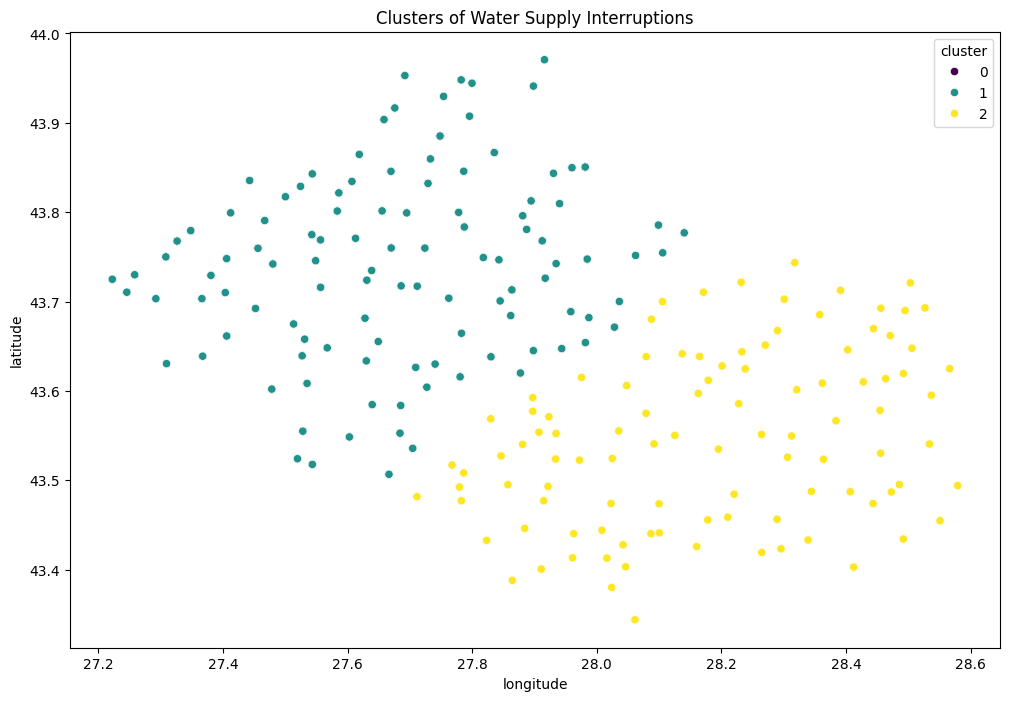

In [11]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

# Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='longitude', y='latitude', hue='cluster', data=df, palette='viridis')
plt.title('Clusters of Water Supply Interruptions')
plt.show()

In [9]:
print(df.columns)

Index(['date', 'name', 'interruption', 'latitude', 'longitude', 'day_of_week',
       'month', 'cluster'],
      dtype='object')


### Elbow method

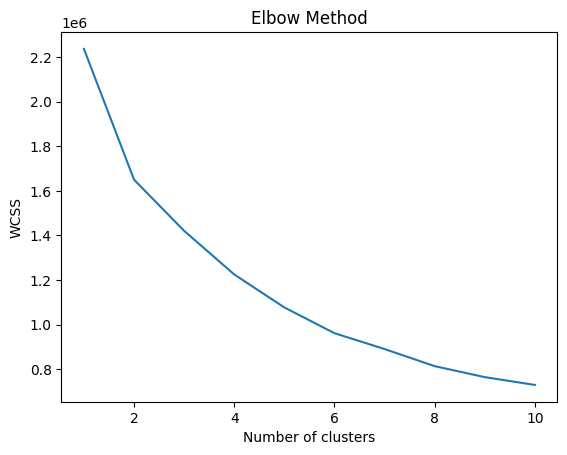

In [62]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
